In [1]:
#Data manipulation libraries
import pandas as pd
import numpy as np

#Visualization libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, CountVectorizer

#Sentiment Analysis
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk

In [2]:
url="../data/E-Commerce_Reviews.csv"
df = pd.read_csv(url)
print(df.shape)

(23486, 11)


### 3. Cleaning up the dataset

#### 3.1 Initial Data Inspection
To start with the cleaning process, a quick look once over of the dataset is useful to identify any outliers.

In [3]:
df.sample(5)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
1648,1648,835,39,Why did i order this?,I really wanted to not like the top for that p...,5,1,2,General Petite,Tops,Blouses
20059,20059,868,65,"Lots of stretch, nice 4 layering","Although this isn't a soft top, i didn't find ...",5,1,0,General,Tops,Knits
16568,16568,1080,35,NaN,"I really wanted this dress to be perfect, but ...",2,0,0,General Petite,Dresses,Dresses
6636,6636,863,34,Love it,This top is awesome. i purchased the gold colo...,5,1,0,General Petite,Tops,Knits
17743,17743,1110,21,NaN,This dress fit perfectly and as i am a bit cur...,5,1,2,General,Dresses,Dresses


The data set contains 23,486 rows of data. At first glance, the dataset has one column that appears to contain redundant index information. The following code is to drop that column.

In [4]:
#we drop the unnamed because it`s a duplicate`
df = df.drop(columns = "Unnamed: 0")

In addition, the column names could be improved by converting to snake case without spaces separated by an underscore, and all letters in lowercase.

In [5]:
df.columns = (df.columns
                .str.replace(' ', '_')
                .str.lower()
             )
print(df.columns)

Index(['clothing_id', 'age', 'title', 'review_text', 'rating',
       'recommended_ind', 'positive_feedback_count', 'division_name',
       'department_name', 'class_name'],
      dtype='object')


#### 3.2 Handling Missing Values
Also, another good practice is to give a check on how many null values there are in the dataset.¶
Note: I personally like doing this before converting the objects into strings to avoid converting NA values into actual strings.

In [6]:
df.isna().sum() 

clothing_id                   0
age                           0
title                      3810
review_text                 845
rating                        0
recommended_ind               0
positive_feedback_count       0
division_name                14
department_name              14
class_name                   14
dtype: int64

Most of the null values are concentrated in the title column. Because we will not be working with this column during the analysis, this does not affect the results. The number of null values in review_text is also significant but this will be addressed in the next block of code

In [7]:
rows_with_na = df[df['review_text'].isna()]
print(rows_with_na)

       clothing_id  age title review_text  rating  recommended_ind   
92             861   23   NaN         NaN       5                1  \
93            1081   31   NaN         NaN       5                1   
98            1133   50   NaN         NaN       5                1   
135            861   35   NaN         NaN       4                1   
142           1126   35   NaN         NaN       5                1   
...            ...  ...   ...         ...     ...              ...   
23258          862   35   NaN         NaN       4                1   
23301          862   52   NaN         NaN       5                1   
23303          823   46   NaN         NaN       5                1   
23470         1104   39   NaN         NaN       5                1   
23480          862   35   NaN         NaN       5                1   

       positive_feedback_count   division_name department_name class_name  
92                           0  General Petite            Tops      Knits  
93     

The following code displays the rows of reviews that are empty (all these coincide with having an empty title as well). Out of the total 23,486 actual rows, 845 have null values on review_text and 3810 null titles. So by removing the empty review_texts rows we reduce the instances of null titles as well. Also, because the analysis is mostly based on review_text, the Nan values on title have no impact on our analysis.¶
The way of dealing with null values will be different depending on the data we are handling and the purpose of the analysis. In this case, I'd like to know what percentage of the dataset these null values on reviews represent.

In [8]:
rows_with_na = df[df['review_text'].isna()]
print(rows_with_na)

       clothing_id  age title review_text  rating  recommended_ind   
92             861   23   NaN         NaN       5                1  \
93            1081   31   NaN         NaN       5                1   
98            1133   50   NaN         NaN       5                1   
135            861   35   NaN         NaN       4                1   
142           1126   35   NaN         NaN       5                1   
...            ...  ...   ...         ...     ...              ...   
23258          862   35   NaN         NaN       4                1   
23301          862   52   NaN         NaN       5                1   
23303          823   46   NaN         NaN       5                1   
23470         1104   39   NaN         NaN       5                1   
23480          862   35   NaN         NaN       5                1   

       positive_feedback_count   division_name department_name class_name  
92                           0  General Petite            Tops      Knits  
93     

In [9]:
total_rows = len(df)
missing_rows = df['review_text'].isna().sum()

percentage_missing = (missing_rows / total_rows) * 100
print(f'Percentage of Missing Values: {percentage_missing:.2f}%')

Percentage of Missing Values: 3.60%


Next step would be to drop rows with missing values from Reviews.

In [10]:
df = df.dropna(subset=['review_text'])

In addition, the 14 Nan values appearing in division_name are going to be removed, this will probably also resolve the Nan of department_name and class_name.

In [11]:
df = df.dropna(subset=['division_name'])

In [12]:
df.isna().sum() 

clothing_id                   0
age                           0
title                      2966
review_text                   0
rating                        0
recommended_ind               0
positive_feedback_count       0
division_name                 0
department_name               0
class_name                    0
dtype: int64

#### 3.3 Checking for Duplicates
The following code evaluates each column of the DataFrame to identify rows containing identical data. The outcome marks duplicates as True while the first occurrence of any duplicate row remains unmarked (ex. False)

In [13]:
df[df.duplicated()]
#Note to self: Why double df[]? Because in order to get it filtered by the boolean indexing.

,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name
21888,1022,37,NaN,"Love, love these jeans. being short they come ...",5,1,0,General,Bottoms,Jeans


Since only one duplicate entry was found in the dataset, it has been removed from the DataFrame.

In [14]:
df = df.drop_duplicates()

#### 3.4 Data Type Optimization

Identifying data types in order to find mismatches and correctly setting data types is important for effective data cleaning and analysis.

In [15]:
df.dtypes

clothing_id                 int64
age                         int64
title                      object
review_text                object
rating                      int64
recommended_ind             int64
positive_feedback_count     int64
division_name              object
department_name            object
class_name                 object
dtype: object

Object data types can be memory-intensive, especially if the column contains long strings or if there are many unique string values. In contrast, using more specific data types like int or category can save memory and improve performance
Additionally, to identify categorical data, obtaining unique values from columns classified as 'Object' types is an effective method for detection.

In [16]:
unique_division_name = df['division_name'].unique()
unique_department_name = df['department_name'].unique()
unique_class_name = df['class_name'].unique()

print("Unique values in the unique_division_name:", unique_division_name)

print("Unique values in the unique_department_name:", unique_department_name)

print("Unique values in the unique_class_name:", unique_class_name)

Unique values in the unique_division_name: ['Initmates' 'General' 'General Petite']
Unique values in the unique_department_name: ['Intimate' 'Dresses' 'Bottoms' 'Tops' 'Jackets' 'Trend']
Unique values in the unique_class_name: ['Intimates' 'Dresses' 'Pants' 'Blouses' 'Knits' 'Outerwear' 'Lounge'
 'Sweaters' 'Skirts' 'Fine gauge' 'Sleep' 'Jackets' 'Swim' 'Trend' 'Jeans'
 'Legwear' 'Shorts' 'Layering' 'Casual bottoms' 'Chemises']


In this case, we could see there are some mispelled words like ¨Intimates¨ and replace the wrong ones.

In [17]:
df['division_name'] = df['division_name'].str.replace('Initmates', 'Intimates')
df['department_name'] = df['department_name'].str.replace('Intimate', 'Intimates')

Converting category columns into Category data type.

In [18]:
df['division_name'] = df['division_name'].astype('category')
df['department_name'] = df['department_name'].astype('category')
df['class_name'] = df['class_name'].astype('category')

In [19]:
df['recommended_ind'].unique()

array([1, 0], dtype=int64)

Checking on how our new dataframe columns’ types look.

In [20]:
df.dtypes

clothing_id                   int64
age                           int64
title                        object
review_text                  object
rating                        int64
recommended_ind               int64
positive_feedback_count       int64
division_name              category
department_name            category
class_name                 category
dtype: object

#### 3.5 Age validation test

In [21]:
min_age = df['age'].min()
max_age = df['age'].max()

if (min_age>18 & max_age<99):
    print(f"Test passed: Age goes from {min_age} to {max_age} which makes sense.")
else:
    print(f"Test not passed, age goes from {min_age} to {max_age} ")

Test passed: Age goes from 18 to 99 which makes sense.


#### 3.6 Data Index Reset
It's often a good idea to reset the index for clarity and consistency, especially if the DataFrame will be used for further transformations or analyses.

In [22]:
df.reset_index(drop=True, inplace=True) 
#Note to self: inplace=True to avoid adding the old index as a new column

### 4 Exploratory Data Analysis (EDA)

#### 4.1 Qualitative Analysis
Dataset's structure: To gain a more comprehensive insight into the organization of the dataframe, a pivot table is utilized. This tool effectively illustrates the hierarchical arrangement of departments within divisions, providing a clear view of the dataset's structure.

In [23]:
pivot_table = pd.pivot_table(df, values='class_name', index=['division_name', 'department_name'], #lists unique class names for each department
                             aggfunc=lambda x: x.unique())

display(pivot_table)

class_name
division_name  department_name                                                   
General        Bottoms          ['Pants', 'Skirts', 'Jeans', 'Shorts', 'Casual...
               Dresses          ['Dresses']
Categories (20, object): ['Blouses...
               Jackets          ['Outerwear', 'Jackets']
Categories (20, objec...
               Tops             ['Blouses', 'Sweaters', 'Knits', 'Fine gauge']...
               Trend            ['Trend']
Categories (20, object): ['Blouses',...
General Petite Bottoms          ['Pants', 'Skirts', 'Jeans']
Categories (20, o...
               Dresses          ['Dresses']
Categories (20, object): ['Blouses...
               Intimates        ['Lounge']
Categories (20, object): ['Blouses'...
               Jackets          ['Jackets', 'Outerwear']
Categories (20, objec...
               Tops             ['Knits', 'Blouses', 'Fine gauge', 'Sweaters']...
               Trend            ['Trend']
Categories (20, object): ['Blouses',...
Intimates      Intimates        ['Intimates', 'Lounge', 'Sleep', 'Swim', 'Legw...

The dataset is structured into three primary divisions: General, General Petite, and Intimates. Each of these divisions encompasses various departments, which are further categorized into classes.¶
General Division: This division includes a range of departments such as Bottoms, Dresses, Jackets, Tops, and Trend.
1. The Bottoms department features classes like Pants, Skirts, Jeans, Shorts, and Casual Bottoms.
2. The Dresses department is singularly classified as Dresses.
3. In the Jackets department, you find classes like Outerwear and Jackets.
4. The Tops and Trend departments have their respective unique classes.

General Petite Division: This division mirrors the General division with departments like Bottoms, Dresses, Jackets, Tops, and Trend. Additionally, it includes the Intimates department. Similar to the General division, the Bottoms, Dresses, Jackets, Tops, and Trend departments in General Petite have corresponding classes. The Intimates department under General Petite features specific classes pertinent to this category.¶
Intimates Division: The Intimates division is more specialized and contains a single department, Intimates, which encompasses various classes tailored to intimate apparel.
To make this analysis more efficient, during the EDA phase we will explore the relationships between variables, and we will exclude department_name from the analysis, using only division_name and class_name as Product Type.

#### 4.2 Quantitative Analysis

##### 4.2.1 Reviews distributions per Division and Ratings

In the following analysis I aim to get a deeper understanding on the Customers' reviews for the Divisions: General, General Petite and Intimates. This offers some insight into the clothing sizes of the customers leaving reviews. Also, the nature of Customers' satisfaction with their purchases.
This block of code allows plotting 2 graphs on the same line. Enumerating the loop enables the loop iteration to coincide with the matplotlib subplot axes

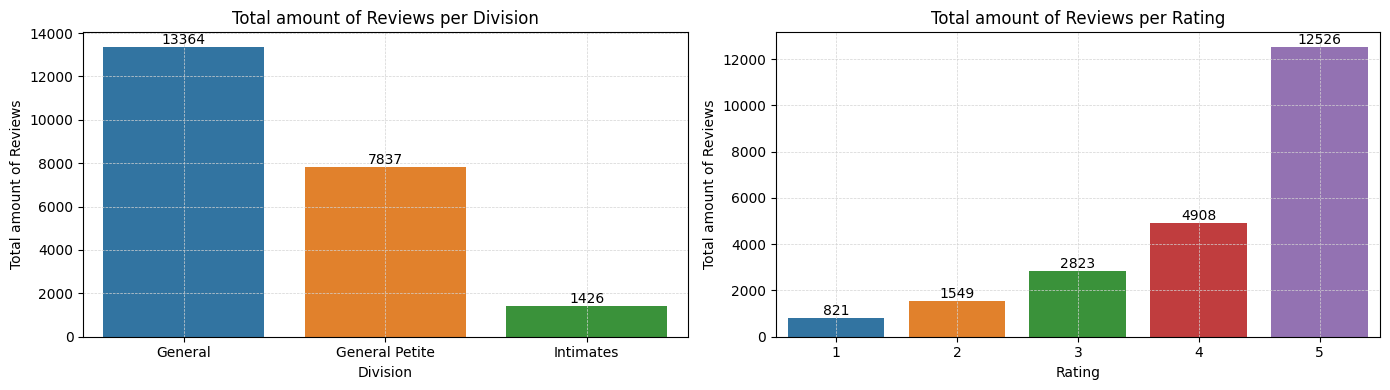

In [24]:
row_plots = ["division_name", "rating"]

f, axes = plt.subplots(1, len(row_plots), figsize=(14, 4), sharex=False) # Create a figure and a set of subplots

# First plot: Total amount of Reviews per Division
division_counts = df['division_name'].value_counts().sort_index()
sns.barplot(x=division_counts.index, y=division_counts.values, ax=axes[0])

for i, count in enumerate(division_counts.values):
    axes[0].text(i, count, str(count), ha='center', va='bottom')

axes[0].set_xlabel('Division')
axes[0].set_ylabel('Total amount of Reviews')
axes[0].set_title('Total amount of Reviews per Division')
axes[0].grid(True, color='lightgrey', linestyle='--', linewidth=0.5, which='both', zorder=0)

# Second plot: Total amount of Reviews per Rating
rating_counts = df['rating'].value_counts().sort_index()
sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[1])

for i, count in enumerate(rating_counts.values):
    axes[1].text(i, count, str(count), ha='center', va='bottom')

axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Total amount of Reviews')
axes[1].set_title('Total amount of Reviews per Rating')
axes[1].grid(True, color='lightgrey', linestyle='--', linewidth=0.5, which='both', zorder=0)

plt.tight_layout()
plt.show()

In terms of Divisions, customers predominantly buy from the General division, General Petite in second place and Intimates in third place.
The displayed plot reveals a concentration of customer reviews primarily in the 5 rating category, indicating that the dataset is predominantly positive in nature.

In [25]:
percentage_5_stars = (df['rating'] == 5).sum() * 100 / len(df)
print(f'5 stars ratings represent {percentage_5_stars:.2f}% of the dataframe')

5 stars ratings represent 55.36% of the dataframe


##### 4.2.2 Ratings distribution per class_name or Type of product


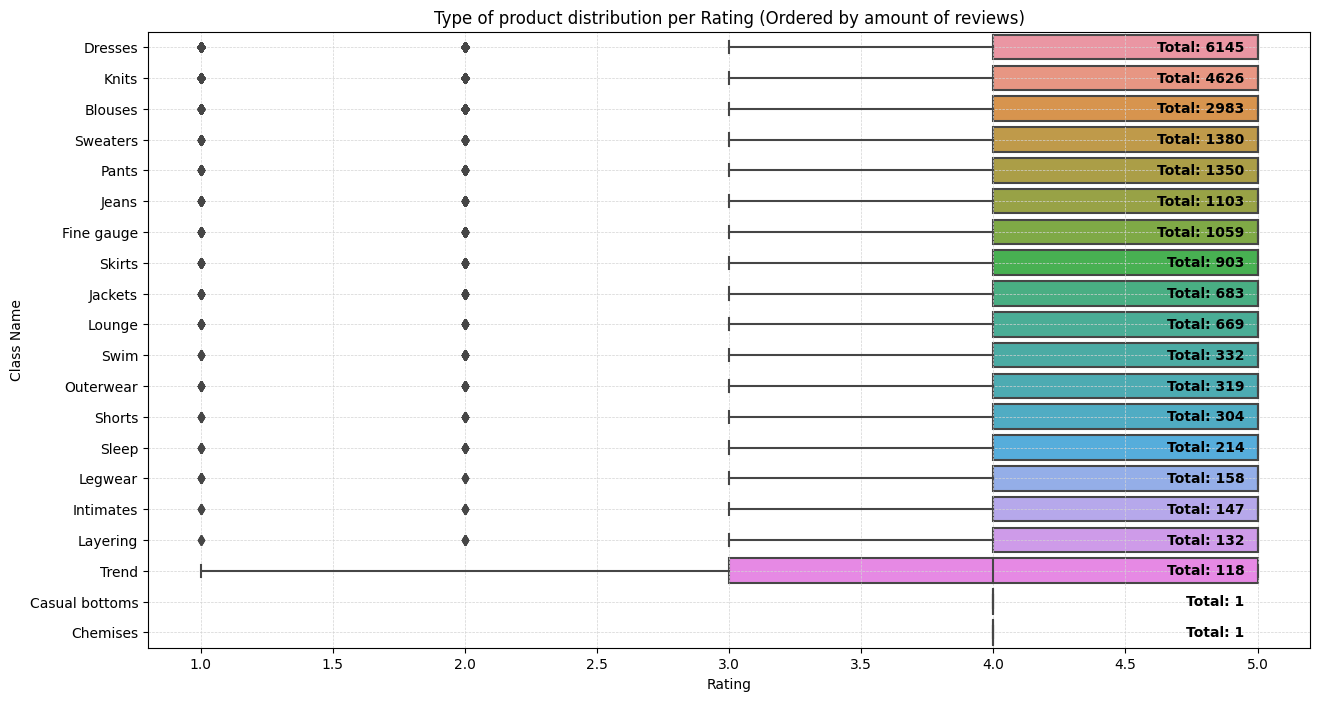

In [26]:
medians = df.groupby('class_name')['rating'].count().sort_values(ascending=False) #median values per group

sorted_names = medians.index.tolist() #order by medians

plt.figure(figsize=(15, 8))
ax = sns.boxplot(x=df['rating'], y=df['class_name'], order=sorted_names)

plt.xlabel('Rating')
plt.ylabel('Class Name')

x_max = ax.get_xlim()[1]

for i, class_name in enumerate(sorted_names):
    count = medians[class_name]
    ax.text(x_max -0.25, i, f'Total: {count}', va='center', color='black', fontweight='bold', ha='right') #total count of reviews

plt.grid(True, color='lightgrey', linestyle='--', linewidth=0.5, which='both', zorder=0) 
plt.title('Type of product distribution per Rating (Ordered by amount of reviews)')
plt.show()

Despite the division and departmental categories, this plot aims to analyze a general view of clothes per class. Displaying the distribution of the ratings, this boxplot makes it easy to detect outliers and which classes have the lower general rating. Totals are showing the total number of reviews per class.
The most common rating in this plot is the highest possible rating (5) with a distribution of the ratings left-skewed,indicating a an overall satisfaction with most of the products and with a couple of outliers located in ratings 1 and 2.
Trend as a class seems to have the lower minimum values. To get further information a quick describe table will be displayed

Another relevant characteristic is that Casual bottoms and Chemises have only one review per Class

In [27]:
one_review = df[(df['class_name'] == 'Casual bottoms') | (df['class_name'] == 'Chemises')]
display(one_review)

,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name
11952,45,26,"Cute pants, but short.",These pants have a really cute design. however...,4,1,0,General,Bottoms,Casual bottoms
12946,10,38,Comfy and cute,This dress is comfortable and a great piece to...,4,1,0,Intimates,Intimates,Chemises


About Casual bottoms, in this case there is only one pair of pants which should be included in 'Pants' Class.¶
For Chemises, it appears to be a misclassification of the source. The review describes shoes that go well with the product, in this case a dress, implying that it is a dress for going out and not a product that would be part of the Intimates category

In [28]:
casual_b = df[(df['class_name'] == 'Casual bottoms')]
chemises = df[(df['class_name'] == 'Chemises')]

indices_to_change = list(casual_b.index) + list(chemises.index) #indices combined in a singles list

new_class_names = ['Pants', 'Dresses']

for i in range(len(indices_to_change)):
    index = indices_to_change[i]
    new_class_name = new_class_names[0] if i < len(casual_b) else new_class_names[1]
    df.at[index, 'class_name'] = new_class_name

Successfully recategorized those 2 cases.

In [29]:
grouped_data = df.groupby('class_name')['rating'].describe()

filtered_data = grouped_data[grouped_data['count'] > 0]

sorted_data = filtered_data.sort_values(by=('mean'))

display(sorted_data) 

,count,mean,std,min,25%,50%,75%,max
class_name,,,,,,,,
Trend,118.0,3.838983,1.313769,1.0,3.0,4.0,5.0,5.0
Dresses,6146.0,4.138789,1.127554,1.0,4.0,5.0,5.0,5.0
Blouses,2983.0,4.142809,1.140846,1.0,4.0,5.0,5.0,5.0
Knits,4626.0,4.145698,1.121563,1.0,4.0,5.0,5.0,5.0
Sweaters,1380.0,4.168841,1.134104,1.0,4.0,5.0,5.0,5.0
Swim,332.0,4.171687,1.125392,1.0,4.0,5.0,5.0,5.0
Outerwear,319.0,4.181818,1.129165,1.0,4.0,5.0,5.0,5.0
Skirts,903.0,4.229236,1.095014,1.0,4.0,5.0,5.0,5.0
Fine gauge,1059.0,4.237960,1.079117,1.0,4.0,5.0,5.0,5.0


This table shows the class statistics sorted by average. Leading the way is Trend with a total of 118 opinions and an average of 3.83. This class is well below the rest, with a mean well below the rest of the classes. The rest of the classes have a spectrum of averages from 4.13 to 4.34. The minimum value of all classes is 1.¶

In [30]:
df_trend_class = df[df['class_name'] == 'Trend']


In [31]:
unique_clothing_ids = df_trend_class['clothing_id'].nunique()

total_reviews = df_trend_class['rating'].count()

print(f"Trend class - Unique Clothing IDs: {unique_clothing_ids}")
print(f"Trend class - Total Reviews: {total_reviews}")

Trend class - Unique Clothing IDs: 38
Trend class - Total Reviews: 118


As we saw previously, the standard distribution of the dataframe is to have 50% of reviews at a 5.0 rating and a mean higher than 4.13. To find where the lowest ratings for the Trend class are located, I'm grouping the 118 reviews by the 42 unique products (by clothing_id) in this class and plotting a boxplot filtered by a mean of 4.13 to expose a non-standard distribution.

In [32]:
grouped_data = df_trend_class.groupby('clothing_id')['rating'].describe()

filtered_data = grouped_data[grouped_data['mean'] < 4.13]

df_filtered_trends = filtered_data.sort_values(by=('mean'))

total_unique_clothing_ids = df_filtered_trends.shape[0]
total_reviews = df_filtered_trends['count'].sum()

print(f"Trend class - Products with a mean < 4.13 - Total Unique Clothing IDs: {total_unique_clothing_ids}")
print(f"Trend class - Products with a mean < 4.13 - Total Reviews: {total_reviews}")

Trend class - Products with a mean < 4.13 - Total Unique Clothing IDs: 20
Trend class - Products with a mean < 4.13 - Total Reviews: 68.0


With a total of 20 products with a mean under 4.13 representing 57% of the total Trend reviews explaining the reasons for this class to have a lower mean than the rest. The reasons of it will be explore in the Sentiment analysis section.

##### 4.2.3 Review distribution by Age

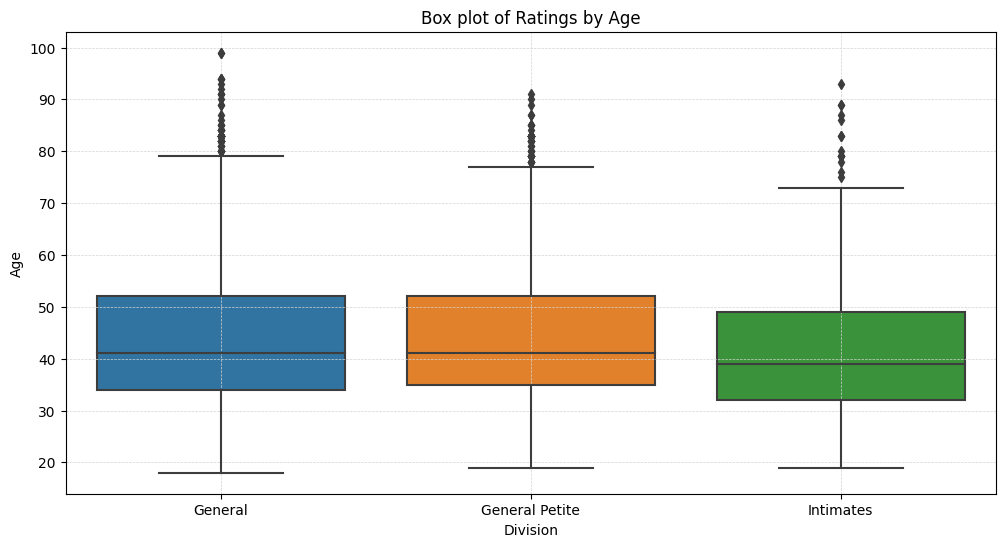

In [33]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='division_name', y='age')
plt.title('Box plot of Ratings by Age')
plt.xlabel('Division')
plt.ylabel('Age')
plt.grid(True, color='lightgrey', linestyle='--', linewidth=0.5, which='both', zorder=0) 
plt.show()

General has a median in 41 years, with an oldest outlier of 100 years old. Meanwhile, General Petite has the same mean but the oldest outlier is 91 years old. Also, the distribution of Age per division shows us that the Intimates division has a generally young audience age, with a mean of 39 years old and the Q3 (75%) is younger than 50 years. This is the youngest of all 3 divisions.

##### 4.2.4 Case Study: 100 products with the lowest average ratings
I will now undertake a case study to identify the 100 products with the lowest average ratings. This will be achieved by grouping the products by their clothing_id and calculating the mean rating for each. This approach will allow us to pinpoint the products with the lowest average ratings.
The first thing to do is to group the ratings per product in order to get the mean of each of them, as well as counting the amount of ratings and counting the ones with rating = 1. In these first lines of code I won’t filter the results, because it could be useful to retain all the available data for now, in case we want to do any other similar inquiries later.¶

In [34]:
ratings_per_product = df.groupby('clothing_id').agg(
    avg_rating=('rating', 'mean'),
    count_ratings=('rating', 'size'),
    count_ones=('rating', lambda x: (x == 1).sum())  # Count reviews with rating of 1
)

With the total data grouped by the amount of ratings, the following code filters by products with more than one rating = 1 and filters the 100 lowest average ratings.
Using df.nsmallest(), a function that returns the first N occurrences ordered by a particular column in ascending order.

In [35]:
filter_higher_one = ratings_per_product[ratings_per_product['count_ones'] > 1]
N = 100
filter_lowest_avg = filter_higher_one.nsmallest(N, 'avg_rating')

#display(filter_lowest_avg)

In [36]:
pd.set_option('display.max_colwidth', None)

In [37]:
display(filter_lowest_avg)

,avg_rating,count_ratings,count_ones
clothing_id,,,
973,1.000000,2,2
569,1.800000,5,2
588,2.000000,4,2
229,2.181818,11,4
1039,2.888889,9,2
...,...,...,...
1059,4.285714,287,8
1009,4.289157,83,3
850,4.290123,324,8


The previous table shows grouped per product, an average rating, the total reviews per product and a count of total '1-star' reviews', this results will be explore deeper on the Business Insights section.

#### 5 Sentiment analysis 

##### 5.1 Overview of TextBlob and VADER Tools
As mentioned in the introduction, Textblob and Vader will be compared to enrich the analysis. First, I'm running a simple test to know how they work.

In [38]:
analyzer = SentimentIntensityAnalyzer() # loading Vader 

text = "This is a good example of VADER sentiment analysis"

vader_sentiment_scores = analyzer.polarity_scores(text)

print("Positive:", vader_sentiment_scores['pos'])
print("Negative:", vader_sentiment_scores['neg'])
print("Neutral:", vader_sentiment_scores['neu'])
print("Compound:", vader_sentiment_scores['compound'])

Positive: 0.266
Negative: 0.0
Neutral: 0.734
Compound: 0.4404


In [39]:
text_blob = TextBlob("This is a good example of a TextBlob")
sentiment_blob = text_blob.sentiment

polarity_blob = sentiment_blob.polarity
subjectivity_blob = sentiment_blob.subjectivity

print("TextBlob Polarity:", polarity_blob)
print("TextBlob Subjectivity:", subjectivity_blob)

TextBlob Polarity: 0.7
TextBlob Subjectivity: 0.6000000000000001


We have two different sentiment analysis tools providing sentiment scores for two similar statements.

**TextBlob**: It provides polarity and subjectivity scores. In Example 1, the polarity score is 0.7, indicating a positive sentiment, and the subjectivity score is 0.6, indicating a moderate level of subjectivity.

**Vader**: It provides positive, negative, neutral, and compound scores. In Example 2, the compound score is 0.6369, which suggests a positive sentiment. The positive score (0.458) is the highest, indicating a positive sentiment.
Both tools generally agree on the sentiment of the given statements, classifying them as positive. However, the exact numeric scores may differ because each tool employs its own sentiment analysis algorithms and scoring systems. Additionally, TextBlob provides a subjectivity score, which VADER does not include in its output.

#### 5.2 Integration of Sentiment Analysis in the Dataset
##### 5.2.1 Adding Textblob and Vader to the dataframe


In [40]:
desc_blob = [TextBlob(desc) for desc in df['review_text']] 

In [41]:
#TEXTBLOB sentiment metrics into the dataframe
df['tb_pol'] = [b.sentiment.polarity for b in desc_blob]
df['tb_subj'] = [b.sentiment.subjectivity for b in desc_blob]

#VADER metrics into dataframe
df['compound'] = [analyzer.polarity_scores(v)['compound'] for v in df['review_text']]
df['neg'] = [analyzer.polarity_scores(v)['neg'] for v in df['review_text']]
df['neu'] = [analyzer.polarity_scores(v)['neu'] for v in df['review_text']]
df['pos'] = [analyzer.polarity_scores(v)['pos'] for v in df['review_text']]

##### 5.2.2 Displaying a selection of columns to understand behavior

In [42]:
selected_columns = ['clothing_id', 'review_text', 'rating', 'recommended_ind', 'tb_pol',
                    'tb_subj', 'compound', 'neg', 'neu', 'pos']

columns_to_highlight = ['rating', 'compound', 'tb_pol']

styled_df = df[selected_columns].head(10).style.hide(axis="index") \
                    .format({"tb_pol": "{:.2f}",
                             'tb_subj': "{:.2f}",
                             "compound": "{:.2f}",
                             "neg": "{:.2f}",
                             "neu": "{:.2f}",
                             "pos": "{:.2f}"}) \
                    .background_gradient(cmap='RdYlGn', subset=columns_to_highlight) 

display(styled_df)

clothing_id,review_text,rating,recommended_ind,tb_pol,tb_subj,compound,neg,neu,pos
767,Absolutely wonderful - silky and sexy and comfortable,4,1,0.63,0.93,0.89,0.00,0.32,0.68
1080,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,0.34,0.73,0.97,0.00,0.70,0.30
1077,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,0.07,0.36,0.92,0.03,0.83,0.14
1049,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0.55,0.62,0.57,0.21,0.40,0.40
847,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,0.51,0.57,0.93,0.00,0.70,0.30
1080,"I love tracy reese dresses, but this one is not for the very petite. i am just under 5 feet tall and usually wear a 0p in this brand. this dress was very pretty out of the package but its a lot of dress. the skirt is long and very full so it overwhelmed my small frame. not a stranger to alterations, shortening and narrowing the skirt would take away from the embellishment of the garment. i love the color and the idea of the style but it just did not work on me. i returned this dress.",2,0,0.18,0.53,0.94,0.00,0.86,0.14
858,"I aded this in my basket at hte last mintue to see what it would look like in person. (store pick up). i went with teh darkler color only because i am so pale :-) hte color is really gorgeous, and turns out it mathced everythiing i was trying on with it prefectly. it is a little baggy on me and hte xs is hte msallet size (bummer, no petite). i decided to jkeep it though, because as i said, it matvehd everything. my ejans, pants, and the 3 skirts i waas trying on (of which i ]kept all ) oops.",5,1,0.13,0.61,0.68,0.04,0.87,0.09
858,"I ordered this in carbon for store pick up, and had a ton of stuff (as always) to try on and used this top to pair (skirts and pants). everything went with it. the color is really nice charcoal with shimmer, and went well with pencil skirts, flare pants, etc. my only compaint is it is a bit big, sleeves are long and it doesn't go in petite. also a bit loose for me, but no xxs... so i kept it and wil ldecide later since the light color is already sold out in hte smallest size...",4,1,0.17,0.50,-0.09,0.04,0.91,0.05
1077,I love this dress. i usually get an xs but it runs a little snug in bust so i ordered up a size. very flattering and feminine with the usual retailer flair for style.,5,1,0.00,0.38,0.72,0.00,0.84,0.16
1077,"I'm 5""5' and 125 lbs. i ordered the s petite to make sure the length wasn't too long. i typically wear an xs regular in retailer dresses. if you're less busty (34b cup or smaller), a s petite will fit you perfectly (snug, but not tight). i love that i could dress it up for a party, or down for work. i love that the tulle is longer then the fabric underneath.",5,1,0.20,0.47,0.87,0.05,0.77,0.18


Both polarity (from Textblob) and compound score (from Vader) are metrics that try to capture the overall sentiment of a text, in slightly different ways. Because they aim to represent similar concepts, it's reasonable to see how each correlates with explicit ratings.

1. Polarity (Textblob):¶
- Ranges from -1 to 1.
- A value closer to 1 means positive sentiment, a value closer to -1 means negative sentiment, and values close to 0 indicate neutral sentiment.
2. Compound Score (Vader):
- Also ranges from -1 to 1.
- A positive compound score signifies a positive sentiment, a negative one signifies a negative sentiment, and scores close to 0 are neutral.
- VADER, being designed specifically for social media text, takes into account intensifiers, emojis, and other nuances.
Before advancing to further analysis, the cleaned dataset, now inclusive of TextBlob and Vader scores, will be stored in the Working space as a CSV file for future iterations.

In [43]:
df.to_csv('../data/tb_vader.csv', index=False)


In [44]:
url2="../data/tb_vader.csv"
df_Vader = pd.read_csv(url2)

In [45]:
df.head()


,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name,tb_pol,tb_subj,compound,neg,neu,pos
0,767,33,NaN,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Intimates,Intimates,Intimates,0.633333,0.933333,0.8932,0.000,0.319,0.681
1,1080,34,NaN,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses,0.339583,0.725000,0.9729,0.000,0.702,0.298
2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,0,General,Dresses,Dresses,0.073675,0.356294,0.9208,0.025,0.831,0.144
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants,0.550000,0.625000,0.5727,0.207,0.396,0.397
4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses,0.512891,0.568750,0.9291,0.000,0.700,0.300


In [46]:
 df[df.duplicated(subset=['clothing_id'], keep=False)]

,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name,tb_pol,tb_subj,compound,neg,neu,pos
0,767,33,NaN,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Intimates,Intimates,Intimates,0.633333,0.933333,0.8932,0.000,0.319,0.681
1,1080,34,NaN,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses,0.339583,0.725000,0.9729,0.000,0.702,0.298
2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,0,General,Dresses,Dresses,0.073675,0.356294,0.9208,0.025,0.831,0.144
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants,0.550000,0.625000,0.5727,0.207,0.396,0.397
4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses,0.512891,0.568750,0.9291,0.000,0.700,0.300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22622,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a great price! it's very easy to slip on and has a very flattering cut and color combo.,5,1,0,General Petite,Dresses,Dresses,0.552667,0.710000,0.9152,0.060,0.582,0.358
22623,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stretchy, shiny material. cut is flattering and drapes nicely. i only found one button to close front... looked awkward. nice long sleeves.\nnot for me but maybe for others. just ok.",3,1,0,General Petite,Tops,Knits,0.091667,0.708333,0.3919,0.069,0.798,0.133
22624,1104,31,"Cute, but see through","This fit well, but the top was very see through. this never would have worked for me. i'm glad i was able to try it on in the store and didn't order it online. with different fabric, it would have been great.",3,0,1,General Petite,Dresses,Dresses,0.414286,0.596429,0.9343,0.000,0.709,0.291
22625,1084,28,"Very cute dress, perfect for summer parties and we","I bought this dress for a wedding i have this summer, and it's so cute. unfortunately the fit isn't perfect. the medium fits my waist perfectly, but was way too long and too big in the bust and shoulders. if i wanted to spend the money, i could get it tailored, but i just felt like it might not be worth it. side note - this dress was delivered to me with a nordstrom tag on it and i found it much cheaper there after looking!",3,1,2,General,Dresses,Dresses,0.322222,0.577778,0.6692,0.061,0.830,0.109


In [47]:

# Create DataFrame
# df = pd.DataFrame(data)

# Calculate average Vader score (mean of tb_pol, tb_subj, and compound), tb_pol	tb_subj	compound	
df['average_vader_score'] = df[['tb_pol', 'tb_subj', 'compound']].mean(axis=1)

# Group by clothing_id, department_name, and class_name to get the average Vader score
result = df.groupby(['clothing_id'], as_index=False)['average_vader_score'].mean()

# Display the result
print(result)


      clothing_id  average_vader_score
0               1             0.535240
1               2             0.400021
2               3             0.494881
3               4             0.601394
4               5             0.701411
...           ...                  ...
1167         1200             0.433619
1168         1202             0.554303
1169         1203             0.554194
1170         1204             0.559646
1171         1205             0.614804

[1172 rows x 2 columns]


In [48]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22627 entries, 0 to 22626
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   clothing_id              22627 non-null  int64   
 1   age                      22627 non-null  int64   
 2   title                    19662 non-null  object  
 3   review_text              22627 non-null  object  
 4   rating                   22627 non-null  int64   
 5   recommended_ind          22627 non-null  int64   
 6   positive_feedback_count  22627 non-null  int64   
 7   division_name            22627 non-null  category
 8   department_name          22627 non-null  category
 9   class_name               22627 non-null  category
 10  tb_pol                   22627 non-null  float64 
 11  tb_subj                  22627 non-null  float64 
 12  compound                 22627 non-null  float64 
 13  neg                      22627 non-null  float64 
 14  neu   

B. Distribution of the compound and polarity against ratin

At this stage in the project, we can present a box plot of the distribution of user ratings (1:5) and sentiment scores (-1:1) determined by the sentiment analysis tools Textblob and Vader. These observations suggest that the two tools apply different thresholds for determining what constitutes positive and negative sentiment

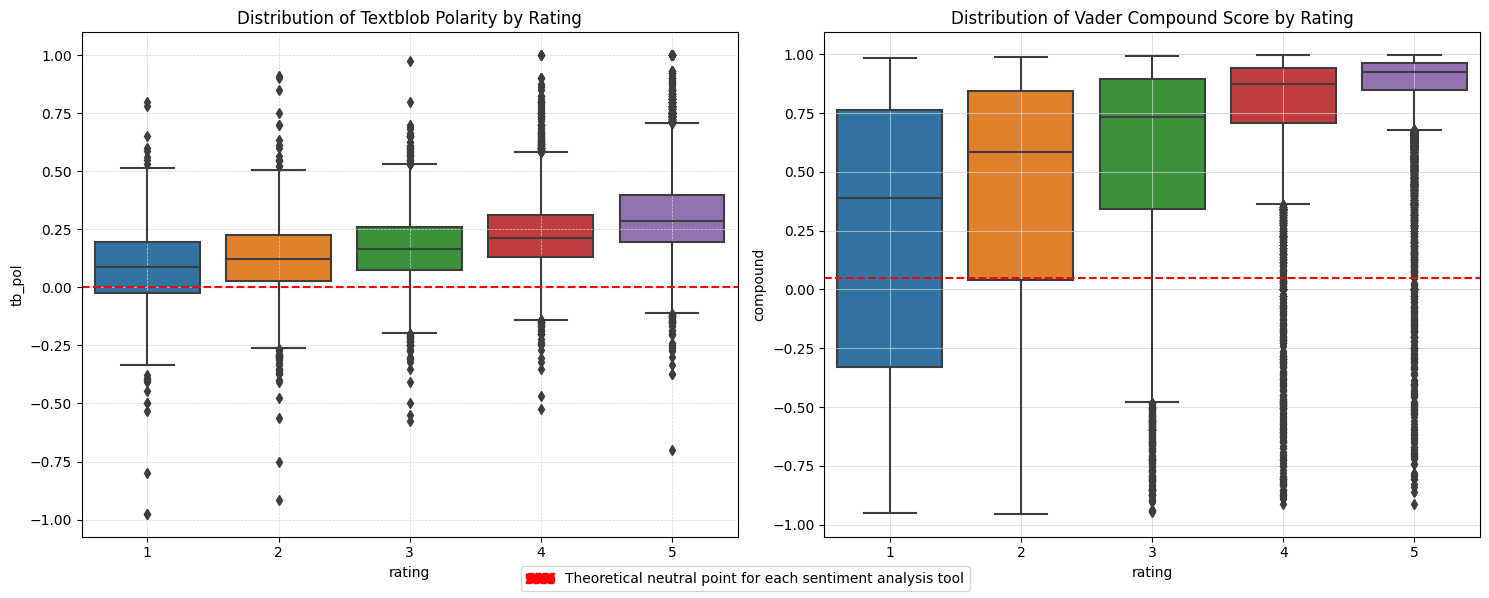

In [49]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=df['rating'], y=df['tb_pol'])
plt.axhline(0.00, color='red', linestyle='--')  # adds horizontal line at y=0.05 for neutral point

plt.title('Distribution of Textblob Polarity by Rating')
plt.grid(True, color='lightgrey', linestyle='--', linewidth=0.5, zorder=0) 

plt.subplot(1, 2, 2)
sns.boxplot(x=df['rating'], y=df['compound'])

plt.axhline(0.05, color='red', linestyle='--')  #adds horizontal line at y=0.05 for neutral point
plt.title('Distribution of Vader Compound Score by Rating')
plt.grid(True, color='lightgrey', linestyle='-', linewidth=0.5, which='both', zorder=0) 

plt.subplots_adjust(bottom=0.2) #subplot layout adjusted to make space for the legend below

red_line = mpatches.Patch(color='red', linestyle='--', label='Theoretical neutral point for each sentiment analysis tool')

plt.figlegend(handles=[red_line], loc='lower center', ncol=1)

plt.tight_layout()
plt.show()

It seems that the Textblob's polarity distribution have less amplitude and is more concentrated than Vader's

In [50]:
tb_medians = df.groupby(['rating'])['tb_pol'].median() 
vader_medians = df.groupby(['rating'])['compound'].median()

print("Textblob Median Sentiment Scores by Rating:")
for rating, median in tb_medians.items():
    print(f"Rating {rating}: {median:.2f}")

print("\nVader Median Sentiment Scores by Rating:")
for rating, median in vader_medians.items():
    print(f"Rating {rating}: {median:.2f}")

Textblob Median Sentiment Scores by Rating:
Rating 1: 0.09
Rating 2: 0.12
Rating 3: 0.16
Rating 4: 0.21
Rating 5: 0.29

Vader Median Sentiment Scores by Rating:
Rating 1: 0.39
Rating 2: 0.59
Rating 3: 0.73
Rating 4: 0.88
Rating 5: 0.93


#### 5.3 Determining Sentiment Thresholds 
**In theory**, Vader proposes that scores above 0.05 are considered positive, below 0.05 negative, and exactly 0.05 neutral. Textblob, on the other hand, considers scores above 0 as positive, below 0 as negative, and 0 as neutral. This discrepancy implies that there is a varying spectrum of sentiment classification between the two tools, which warrants recalibration of the thresholds to align with empirical user rating data.
For a better interpretation of the sentiment of a text from the analysis, new thresholds will be defined to better fit this dataset. If we take a baseline assumption that ratings of 3 out of 5 are considered neutral then we can determined the sentiment thresholds for Textblob and Vader as their sentiment scores for rating 3 in the above polarity distribution boxplot. <span style="color:green">Therefore we can say that the neutral scores for Textblob and Vader would be 0.16 and 0.73.</span>.

#### 5.4 Sentiment Classification
The following blocks of code aim to classify the tools’ sentiment results, transforming Textblob's polarity, Vader's compound and User's ratings into the categories: Positive, Negative and Neutral.

In [51]:
#VADER INTO SENTIMENT
def find_sentiment_vader(compound_score):
    if compound_score > 0.73:
        return "POSITIVE"
    elif compound_score < 0.73:
        return "NEGATIVE"
    else:
        return "NEUTRAL"   
    
df['vader_sentiment'] = df['compound'].apply(find_sentiment_vader)

In [52]:
#TEXTBLOB INTO SENTIMENT
def find_sentiment_textblob(tb_pol):
    if tb_pol > 0.16:
        return "POSITIVE"
    elif tb_pol < 0.16:
        return "NEGATIVE"
    else:
        return "NEUTRAL"

df['tb_sentiment'] = df['tb_pol'].apply(find_sentiment_textblob)

In [53]:
#RATINGS INTO SENTIMENT
def find_sentiment_rating(rate):
    if rate > 3:
        return "POSITIVE"
    elif rate < 3:
        return "NEGATIVE"
    else:
        return "NEUTRAL"

df['rating_sentiment'] = df['rating'].apply(find_sentiment_rating)

#### 5.5 Classification Stats
<span style="color:green">Once the classification have been applied to the dataframe, the following turns them into insightful results.</span>

In [54]:
def compare_sentiments(row):
    return {
        'tb_match': row['tb_sentiment'] == row['rating_sentiment'],
        'vader_match': row['vader_sentiment'] == row['rating_sentiment']
    }

comparison_df = pd.DataFrame([compare_sentiments(row) for _, row in df.iterrows()])

results = {
    'Textblob': {
        'matches': comparison_df['tb_match'].sum(),
        'not_matches': (~comparison_df['tb_match']).sum(),
        'accuracy': comparison_df['tb_match'].mean() * 100
    },
    'Vader': {
        'matches': comparison_df['vader_match'].sum(),
        'not_matches': (~comparison_df['vader_match']).sum(),
        'accuracy': comparison_df['vader_match'].mean() * 100
    }
}

for analyzer, stats in results.items():
    print(f"{analyzer} Accuracy: {stats['accuracy']:.2f}%")
    print(f"{analyzer} Total matches: {stats['matches']}")
    print(f"{analyzer} Total not matches: {stats['not_matches']}")
    
#Note to self: This results dictionary divided in 2 parts: the tool, inside each tool there is these 3 elements. 
#analyzer&stats asigned to be able to call the elements

Textblob Accuracy: 66.56%
Textblob Total matches: 15060
Textblob Total not matches: 7567
Vader Accuracy: 71.03%
Vader Total matches: 16072
Vader Total not matches: 6555


In [55]:
#test_comparison_df = df.apply(compare_sentiments, axis=1)
#print(test_comparison_df)

#Note to self: double checking how the code works, df.iterrows() for each line selects pairs of (index, row data). 
#Example:
#0        {'tb_match': True, 'vader_match': True}  
#Then it ignores the index '0' because of this: for _, row in 
#And transforms the list of mdictionaries into a DataFrame

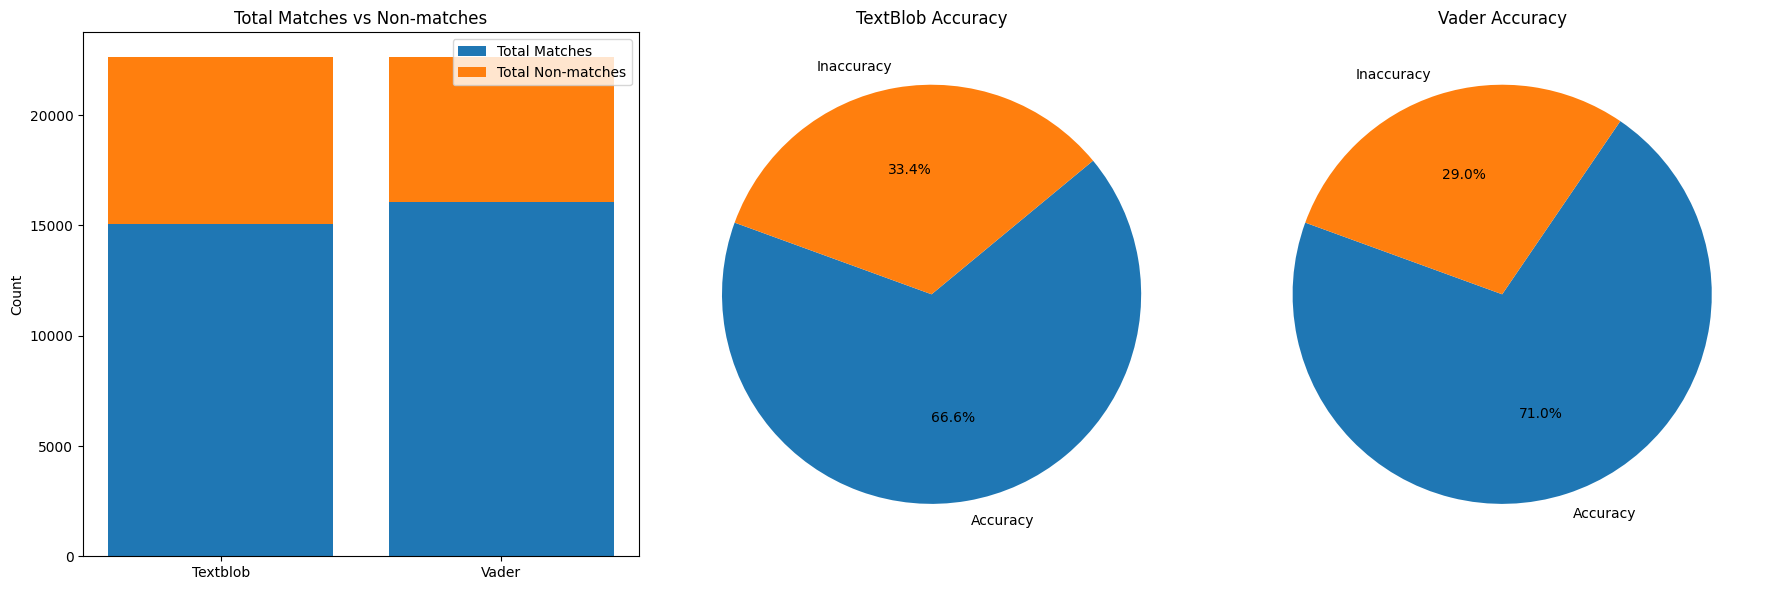

In [56]:
analyzers = list(results.keys())
accuracies = [results[analyzer]['accuracy'] for analyzer in analyzers]
matches = [results[analyzer]['matches'] for analyzer in analyzers]
not_matches = [results[analyzer]['not_matches'] for analyzer in analyzers]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

#BAR PLOTS
axes[0].bar(analyzers, matches, label='Total Matches')
axes[0].bar(analyzers, not_matches, bottom=matches, label='Total Non-matches')
axes[0].set_title('Total Matches vs Non-matches')
axes[0].set_ylabel('Count')
axes[0].legend()

#PIE CHARTS
axes[1].pie([accuracies[0], 100-accuracies[0]], labels=['Accuracy', 'Inaccuracy'], autopct='%1.1f%%', startangle=160)
axes[1].set_title('TextBlob Accuracy')

axes[2].pie([accuracies[1], 100-accuracies[1]], labels=['Accuracy', 'Inaccuracy'], autopct='%1.1f%%', startangle=160)
axes[2].set_title('Vader Accuracy')

plt.tight_layout()
plt.show()

<span style="color:red">The above graphs show that VADER has a higher accuracy level than Textblob, of 71% vs 66% respectively. In numeric terms, this is a difference of over 1000 cases. The 2 tools probably has a similar way to analyze it, do they coincide in the cases? What are these cases were it is not accurate?</span>

**Validation test**

In [57]:
if (results['Textblob']['matches'] + results['Textblob']['not_matches'] == len(df) & results['Vader']['matches'] + results['Vader']['not_matches'] == len(df)): # and (vader_matches + vader_not_matches == len(df)):
   print("Test passed: All reviews have been accounted for.")
else:
   print("Test not passed: The counts do not match the number of reviews.")

Test passed: All reviews have been accounted for.


#### 5.6 Correlation with Ratings

In [58]:
print("Correlation between rating and TextBlob polarity:", df['rating'].corr(df['tb_pol']))
print("Correlation between rating and VADER compound:", df['rating'].corr(df['compound']))

Correlation between rating and TextBlob polarity: 0.38641320355241193
Correlation between rating and VADER compound: 0.47352787582404293


Since both metrics have a positive correlation, it means that as user ratings increase, both sentiment metrics tend to increase. Vader has a higher correlation with ratings but it is still a low one on 0.47, against 0.38 of Textblob. Vader is more accurate at predicting the rating than Textblob.
These results are aligned with the sentiment classification.
Next, we will have a deeper focus on which cases the results from both tools coincide, and which are the cases where none of the tools could provide an accurate result. For this, we firstly run a function that shows us how accurate both the tools are when either one of them identifies the correct rating, compared to when neither of them succeed in predicting the actual rating. Then, to find out what’s gone wrong in the latter cases, we show a distribution of ratings where neither of the tools got it right.

In [59]:
def classify_accurate(row):
    if row['rating_sentiment'] == 'POSITIVE' and (row['tb_sentiment'] == 'POSITIVE' or row['vader_sentiment'] == 'POSITIVE'):
        return 'accurate'
    elif row['rating_sentiment'] == 'NEGATIVE' and (row['tb_sentiment'] == 'NEGATIVE' or row['vader_sentiment'] == 'NEGATIVE'):
        return 'accurate'
    else:
        return 'no_accurate'

df['accurate_type'] = df.apply(classify_accurate, axis=1)

accurate_count = df['accurate_type'].value_counts().get('accurate', 0)
no_accurate_count = df['accurate_type'].value_counts().get('no_accurate', 0)

total_reviews = len(df)

print(f"Accuracy by at least one tool: {accurate_count / total_reviews * 100:.2f}%")
print(f"Non accurate by any of the tools: {no_accurate_count / total_reviews * 100:.2f}%")

Accuracy by at least one tool: 79.00%
Non accurate by any of the tools: 21.00%


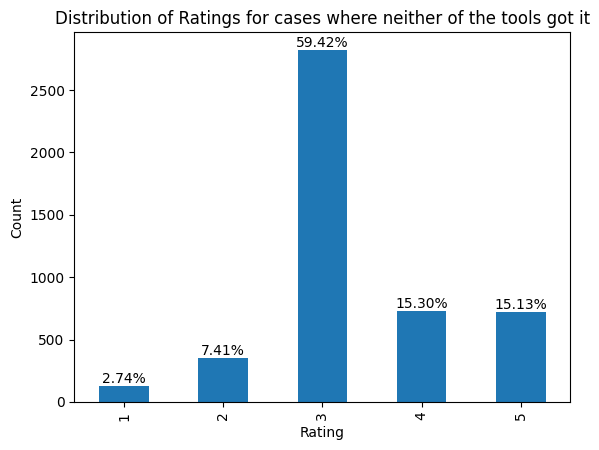

In [60]:
accurate = df[df['accurate_type'] == 'accurate']
no_accurate = df[df['accurate_type'] == 'no_accurate']

rating_counts = no_accurate['rating'].value_counts().sort_index()
total = rating_counts.sum()

rating_counts.plot(kind='bar')
plt.title('Distribution of Ratings for cases where neither of the tools got it')
plt.xlabel('Rating')
plt.ylabel('Count')

for index, value in enumerate(rating_counts): #percentage per bar
    percentage = f'{(value / total) * 100:.2f}%'
    plt.text(index, value, percentage, ha='center', va='bottom')

plt.show()

Most of the cases where none of the tools rated it accurately are rated by the Client with 3 stars, considering them Neutral. This is a clear limitation of the two tools, the main weakness of these are the cases categorized as neutral that do not express love or hate in an evident way.
In addition, the number of words per review could be another characteristic of incorrect classifications

In [61]:
def count_words(text):
    return len(text.split())

df['word_count'] = df['review_text'].apply(count_words)

In [62]:
average_word_count = df.groupby('accurate_type')['word_count'].describe()
print(average_word_count)

                 count       mean        std  min   25%   50%   75%    max
accurate_type                                                             
accurate       17876.0  59.380622  28.585751  2.0  35.0  58.0  87.0  115.0
no_accurate     4751.0  63.343717  28.118852  2.0  40.0  63.0  92.0  115.0


As we can see from the above table, there is a correlation between text length and accuracy group. The longer the text is, the less accurate results the tools gave. Interestingly, the difference between the groups of correct and incorrect identifications were not drastically different; with medians of 59.37 and 63.34 respectively. This could be explained by the high portion of neutral ratings being inaccurately identified by the tools. The third percentile is also slightly higher (87.0 - 92.0). However, the maxima and minima are the same for both groups.
One explanation for this could be that the longer the review is, the more expressions and phrases the client writes. Rather than one simple expression of review, there are many other words unrelated to the overall rating.It could also be as a result of irony, with opposite meanings that require context and a more nuanced human understanding. All of these possibilities result in a ‘confusion’ of the tools

### 6. Business Insights
In this section, we will explore potential opportunities to extrapolate actionable business insights from the analysis that has been performed so far.

##### 6.1 Trend's class opportunities based on reviews
In this section, the finding made during the EDA related to Trend as a class where this class has a lower mean than the other ones is going to be addressed with the purpose of getting business actionables.

In [63]:
df_trend_class = df[(df['class_name'] == 'Trend') & 
                    (df['rating'] < 3)]

In [64]:
selected_columns = df_trend_class[['age', 'rating', 'review_text']]

sorted_df = selected_columns.sort_values(by='rating')

display(sorted_df)

,age,rating,review_text
11858,64,1,"I was so excited about this top, and so disappointed when it arrived today. the lace part is lovely, but the skirt part is a crinoline type fabric that balloons out at the sides. it is gathered at the sides rather than pleated, and there is no way to get it to lay flat. the back center section is pleated. why couldn't they have had the pleats all around? this will be going back with much regret."
4301,51,1,I am not sure who would look good in this dress. it is extremely oversized with tons of fabric that will not flatter anyone!
4616,46,1,"This runs sooo big! i normally wear a large ( 145lb, 5'-4"", 36dd) but due to the limited sizing small or medium i chose small because it looked big on the model and this style of dress seem to run large. the size small that i ordered couldve fit two people easily together! i loved the pattern, color and the slip underneath actually fit well but i dont want to look like im wearing a tent, lol. also, the back is slightly longer than the front, something i couldnt see from the pictures online."
4834,25,1,"I thought this would be a cute business attire skirt. i hate to say it, but i felt like it flared out as if i were amelia bedelia or some whacky children's book character and not retailer. the fabric made it look bulky. i sadly had to return it."
6408,25,1,"The jeans look so different online! the pair i got did not have the stone washed look and was completely different cut. the rise is not as stated and is actually 10.5 inches! also, i'm a true 25 and the waist is like a 27, but the legs are super skinny. i'm so disappointed and i'm not even sure if is worth swapping out for a smaller size. these look more like men's cut jeans."
11004,43,1,"I had loved this on-line when i saw the pretty floral pattern. however, in person, it is such a disappointment. the quality of the fabric and the fit are just very poor."
18495,54,1,"The dress is pretty, i ordered a 4 and 6 not knowing how it ran, i took both back the neck is too tight!"
21173,57,1,I so wanted to like this dress i ordered it for summer graduation and weddings. i usually wear a 4/s and even the xs is was too pig. it drapes like a smock. the material is heavy. the only thing pretty about this dress is the pattern and color.\r\n\r\nstill looking for the perfect dress...
11864,53,1,"When i unwrapped this a chemical ""stink"" hit me that amost knocked me over. it was really unbearable and i m not overly sensitive to smells. second it was way too large with a boxy unflattering cut. the waist sits very high at elbow height and every below the waist the material balloons out in a rediculous manner. i wonder if they had it pinned down somehow on the picture here. with a more flattering cut i might have decided to wash it a few times to get the stink out. i do not recommend this fo"
15483,52,1,"I have purchased a lot from retailer but lately, some of the items have been disappointing in quality.verses cost, this being one. the picture is nice but the actual blouse is nothing like this. the size was not accurate so buy a size bigger because of the sleeves."


The above result shows the filtered reviews of the Trend class with ratings under 3. Out of these 21 reviews, roughly half complain about the size of the product, saying that it is bigger or smaller than what they expect from a normal fit. Although many of them highlight the colors and patterns of the product in the positive, another significant group found that the products’ colors don't match the pictures on the website.

These findings present an opportunity for a business insight to improve their size guide or graphics on the website. This could result in an improvement of sentiment towards the items, and thus the rating given

##### 6.2 Case study: 100 products with the lowest average ratings
As a summary of the EDA, the type of distribution is often positive for reviews in this dataframe. If ratings are uniformly high, it could indicate excellent performance or, in some cases, it could suggest a bias in data collection or an unrepresentative sample. For example, some online platforms actively encourage users to leave reviews, sometimes offering incentives. This can influence the likelihood of customers leaving reviews, regardless of whether their experience was particularly positive or negative.

Therefore I will opportunities for improvement for those 100 products.

A subdataframe will be created with the results and merged it to the DataFrame to be able to display columns with relevant information

In [65]:
filtered_df = df[df['clothing_id'].isin(filter_lowest_avg.index)] #filter by clothing_id

grouped_ratings = filtered_df.groupby('clothing_id')['rating'] #group by clothing_id per rating


idx = grouped_ratings.idxmin() #index of the minimum rating for each group

lowest_rated_reviews = df.loc[idx]

lowest_avg_ratings = pd.merge(filter_lowest_avg, lowest_rated_reviews[['clothing_id','age', 'review_text', 'rating', 'class_name', 'tb_pol', 'compound', 'division_name']], 
                  left_index=True, right_on='clothing_id', how='left') #merge products per ratings with lowest-rated reviews

sorted_df = lowest_avg_ratings.sort_values(by='count_ones', ascending=False)

display(sorted_df)

,avg_rating,count_ratings,count_ones,clothing_id,age,review_text,rating,class_name,tb_pol,compound,division_name
200,4.192802,778,36,862,44,Love the fabric of this shirt even though it was thinner than i expected. it is soft to the skin and flattering. however i returned it because it is made for women with long torso and shorter shoulders.,1,Knits,0.112500,0.7579,General
2405,4.189463,987,32,1078,49,"I wanted to love this. couldn't wait for it to arrive. unfortunately, it doesn't look anything like the picture. i usually wear a m/l in holding horses so i ordered a l but as soon as i held it up i noticed it was ridiculously large. the fabric is on the heavy side so the dress just hangs in a very unflattering way. and, it is extremely shimmery. i love velvet, but the texture and sheen of this dress was just over the top. sadly, it is going back.",1,Dresses,0.030844,0.6047,General Petite
2660,3.927536,414,24,868,33,"I purchased this top on sale and was really excited about the style. it fit great the first time i wore it. i washed it once, according to the care instructions. after washing it in cold water and allowing it to air dry, it was basically ruined. it shrunk up in length widened out about two inches. i'm pretty bummed about it because it was cute.",1,Knits,0.267593,0.9485,General
931,4.185034,735,23,1094,67,Very cheap looking material. looks cheap to cost $158.,1,Dresses,0.460000,0.0000,General
850,4.265597,561,17,1081,42,"I loved the photo of this dress. upon examination of the dress (and trying it on) after receiving in the mail, the dress shown online is nothing like the dress i received save for the pattern. the dress i received has a side zip as well as a belt and no pleats on the top. the bottom is also cut straight across not as it appears in the photo. turns out it is not as flattering as it should appear.",1,Dresses,0.466667,0.6734,General
...,...,...,...,...,...,...,...,...,...,...,...
5569,4.000000,39,2,880,28,This shirt would be perfect if i needed a canopy on my tent. this shirt runs ridiculously large. purchased a medium and it should be labeled an xl. no impressed with the pattern in person. looks cheap. will be returning.,1,Knits,0.278571,-0.0654,General
11858,1.800000,5,2,569,64,"I was so excited about this top, and so disappointed when it arrived today. the lace part is lovely, but the skirt part is a crinoline type fabric that balloons out at the sides. it is gathered at the sides rather than pleated, and there is no way to get it to lay flat. the back center section is pleated. why couldn't they have had the pleats all around? this will be going back with much regret.",1,Trend,0.077778,-0.5911,General
2757,4.058824,34,2,1103,33,"This dress fits awfully. it's not short, as pictured in photo. it hit just above my knees. it looked like sack. i would've, also, felt like i was choking all night with it clasped around my neck. it, potentially, may look okay on someone who is very tall, skinny, and lanky, but i have my doubts about that too.",1,Dresses,0.140000,-0.2144,General
4078,4.108108,37,2,1053,51,"I thought these were gorgeous and was going to buy them although the price was a bit high. in fact, two separate women came up to me as i was walking around the store and asked where i got the pants because the colors are so vivid. however, as we were looking at the items, we noticed that both the green and the blue both had several small holes in them due to stitching quality, as the previous reviewer noted. therefore, none of us purchased the pants.\r\n\r\nthe staff at the store were very helpful",1,Pants,0.044333,0.7960,General


Validation test: Before using .loc[], you can check if the indices in idx are present in df using set(idx).issubset(df.index). This will return True if all indices in idx are in df.

In [66]:
if (set(idx).issubset(df.index) == True):
    print("Test passed: idx´s index has everything of the df index")
else:
    print("Test not passed")    
    
#.issubset() to check if the indices are present in the original DataFrame is prudent. It ensures the integrity of your analysis.

Test passed: idx´s index has everything of the df index


From this analysis, it can been noticed that the product (clothing_id = 862) not only is part of the 100 lowest rated products but also has 36 1-star reviews.

In [67]:
#Word Cloud general code and personalized stopwords
custom_stop_words = ['just', 'really', 'look','looked','wasn', 'received','trying','looking','started','isn','didn','felt', 'did','does', 'wear','know', 'couldn','tried', 'looks', 'way', 'ordered', 'dress', 'like', 'thought', 'doesn', 'don','ve','going','isnt', 'come','try', 'got' ] 

combined_stop_words = ENGLISH_STOP_WORDS.union(custom_stop_words) #Adding personalized words 

combined_stop_words_list = list(combined_stop_words) #Note to self: convert into a list for analysis

vectorizer = CountVectorizer(stop_words=combined_stop_words_list)

In [68]:
star1_product = df[(df['clothing_id'] == 862) & (df['rating'] <= 2)]

In [69]:
total_rows = len(star1_product)
print(f"Total reviews for the product '862' with ratings below 2: {total_rows}")

Total reviews for the product '862' with ratings below 2: 83


In [70]:
matrix = vectorizer.fit_transform(star1_product['review_text'])
frequent_words = vectorizer.get_feature_names_out()
word_counts = matrix.sum(axis=0)
word_freq = dict(zip(frequent_words, word_counts.tolist()[0]))
sorted_word_freq = sorted(word_freq.items(), key=lambda item: item[1], reverse=True)[:20] # Top 20 words
sorted_word_freq

#wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

#plt.figure(figsize=(15, 10))
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis('off')  #Note to self: off the axis
#plt.show()

[('shirt', 42),
 ('fabric', 22),
 ('fit', 18),
 ('color', 17),
 ('cute', 16),
 ('material', 16),
 ('bought', 14),
 ('love', 14),
 ('return', 13),
 ('size', 13),
 ('small', 13),
 ('washed', 13),
 ('disappointed', 12),
 ('wash', 12),
 ('dry', 11),
 ('online', 11),
 ('quality', 11),
 ('shrunk', 11),
 ('white', 11),
 ('good', 10)]

Out of the 83 reviews, a deeper view will be displayed in those that mention 'shrunk' and 'disappointed'. This is because they seem highly likely to indicate a problem with the product

In [72]:
import nltk
nltk.data.path.append("../data/")  # Adjust the path as needed
nltk.download('punkt_tab')
def contains_key_words(text):
    words = word_tokenize(text.lower())  #tokenization
    return 'shrunk' in words or 'disappointed' in words

filtered_df = star1_product[star1_product['review_text'].apply(contains_key_words)]

display(filtered_df[['rating', 'review_text', 'clothing_id']])

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


,rating,review_text,clothing_id
1516,2,"Gorgeous color and great price, but too low cut and because of the design, a cami's wouldn't work. disappointed",862
2057,1,"I bought this top and it ran huge, i had to get an extra small. well then i wash it according to the instructions and it shrunk horribly! like its so small now my 3 yr old could probably wear it! i'm so sad, i really liked this top....but for it to shrink after one wear is not acceptable.",862
2884,1,I loved this shirt until the first time i washed it. it shrunk so much it became unwearable. when i returned it the salesperson said she had also bought this shirt and the same thing happened.,862
2888,1,"I was so excited to find this shirt on sale at my local retailer store. but, i did not notice the high percentage of rayon in the fabric, which caused the shirt to shrink significantly in the wash (even when following washing instructions). i washed it on cold with woolite and it is about half the length it was initially! i'm so disappointed. how can you make a shirt that can't withstand washing?!",862
2891,1,So disappointing! everything i've owned from bordeaux has washed well and stood the test of time. one wash and this was ruined! shrunk terrible even after washing in cold water on delicate and laying flat to dry. completely ruined. returned it.,862
2898,1,It's a cute top but once i washed in cold water and laid flat to dry it shrunk and lost it's shape. very disappointed. i am going to return top.,862
2905,2,"I loved this shirt so much i bought it in 4 colors. however, two of them shrunk. i was very disappointed.",862
2937,1,"I tried on and bought this shirt in my usual size and it fit long and loose but still had great shape. after hand washing in cold water and air drying, as per instructions on the tag, the shirt shrunk significantly. so much so that my stomach shows if i raise my arms at all. it also lost its shape, and now looks very boxy and is very unflattering. i won't be wearing it and am disappointed i didn't even get to wear it once!",862
5663,1,"Boxy, short & wide! luv this brand but super disappointed with this design...",862
6520,1,"I was really excited for this top to arrive and was really disappointed once i tried it on. i am sure this is a gorgeous top on someone with a straighter or more slender frame. it is good quality and looks fine on the hanger. i think the color in the picture online accurately shows the color. ladies with hips or a booty, beware...this looked horrible on me! it clung to my butt and didn't hang nice and straight like it does in this picture. i expected the fabric to have a little give to it but it",862


Continuing with the analysis made in section 3 of Exploratory Data analysis, the following blocks of code show main points of improvement for the products

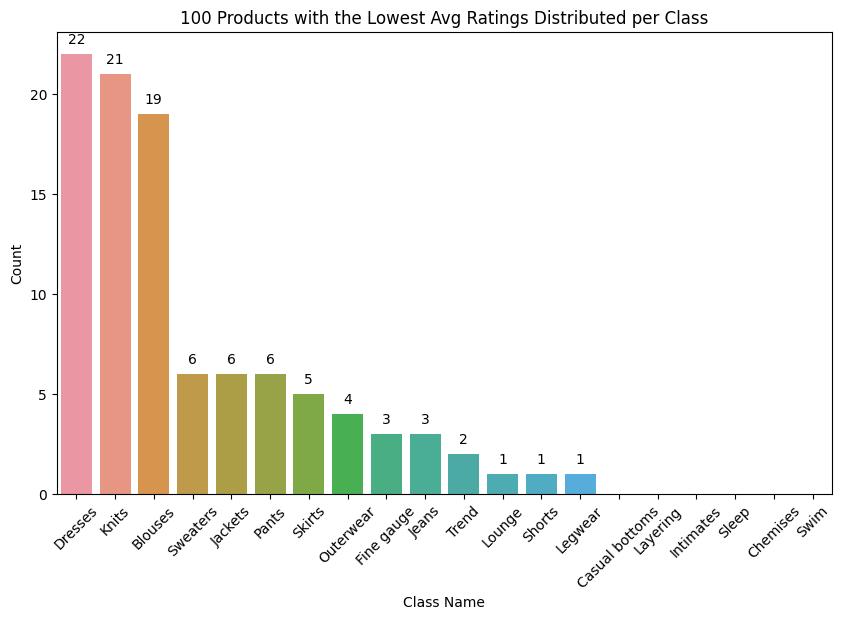

In [166]:
#counting per class
class_counts = lowest_avg_ratings['class_name'].value_counts()

plt.figure(figsize=(10, 6))
bar_plot = sns.countplot(x='class_name', data=lowest_avg_ratings, order=class_counts.index)

#totals per bar
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.0f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 10), 
                      textcoords = 'offset points')

plt.title('100 Products with the Lowest Avg Ratings Distributed per Class')
plt.xlabel('Class Name')
plt.ylabel('Count')
plt.xticks(rotation=45)  #rotation of labels
plt.show()

We will look at Dresses and Knits in further detail, as they have the highest ratio of lowest ratings
Since Dresses in the General division are the ‘star’ product of this e-commerce store, with the most sales, it’s important to find out the key points of improvement by looking at a Word Cloud of the review_text. In order to improve the accuracy of the Word Cloud, stopwords and some verbs that do not provide useful information have been removed

In [73]:
dresses = lowest_avg_ratings[(lowest_avg_ratings['class_name'] == 'Dresses') & 
                             (lowest_avg_ratings['division_name'] == 'General')]

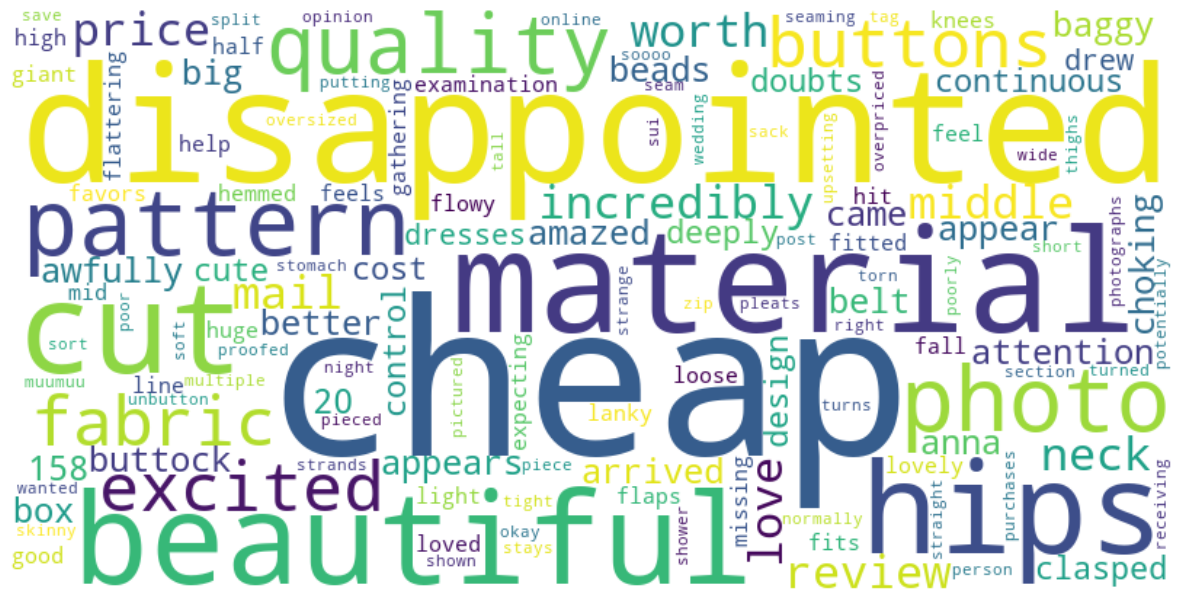

In [74]:
matrix = vectorizer.fit_transform(dresses['review_text'])
frequent_words = vectorizer.get_feature_names_out()
word_counts = matrix.sum(axis=0)
word_freq = dict(zip(frequent_words, word_counts.tolist()[0]))
#sorted_word_freq = sorted(word_freq.items(), key=lambda item: item[1], reverse=True)[:20] # Top 20 words
#sorted_word_freq

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  #Note to self: off the axis
plt.show()

The words ‘disappointed’ and ‘cheap’ seem to be the most common, let’s have a closer look at these reviews

In [75]:
def contains_key_words(text):
    words = word_tokenize(text.lower())  #tokenization
    return 'disappointed' in words or 'cheap' in words

filtered_df = lowest_avg_ratings[lowest_avg_ratings['review_text'].apply(contains_key_words)]
filtered_df = lowest_avg_ratings[(lowest_avg_ratings['class_name'] == 'Dresses') & 
                             (lowest_avg_ratings['division_name'] == 'General')]

display(filtered_df[['rating', 'review_text', 'clothing_id']])

,rating,review_text,clothing_id
11348,1,"I'm so disappointed. the dress looked lovely in the box, but when i started to unbutton it to try it on, two buttons split in half! it's going right back.",1079
8544,1,Was so excited to get this dress because i thought it was cute and i love flowy and big dresses - however this looks huge. the material is not soft so it doesn't fall well. it just stays proofed out so from the back you look like a giant!!,1088
1060,1,"There is no way this is worth the price. i was deeply disappointed when it arrived. the material is thin and feels cheap. i love the design, and anna sui, but this is just so overpriced.",1076
1389,1,"Looks fitted on, but this just turned out to be an oversized muumuu on. the fabric also felt cheap.",1087
1293,1,I'm so incredibly disappointed. the dress is beautiful but the one i received is torn and has multiple strands of beads missing. poor quality control.,1098
374,1,"I don't normally review my purchases, but i was so amazed at how poorly this dress was made, i couldn't help myself but to post a review. the neck line isn't even hemmed down so it flaps up. the material is thin and feel cheap. this dress isnt even worth $20 in my opinion. i was expecting a well made, good quality dress for the high price tag.",1104
2757,1,"This dress fits awfully. it's not short, as pictured in photo. it hit just above my knees. it looked like sack. i would've, also, felt like i was choking all night with it clasped around my neck. it, potentially, may look okay on someone who is very tall, skinny, and lanky, but i have my doubts about that too.",1103
6978,1,So disappointed! beautiful dress in the photographs but the cut was incredibly strange. loose and baggy through the top and mid-section but tight around the buttock and thighs.,1092
931,1,Very cheap looking material. looks cheap to cost $158.,1094
2041,1,This dress is so beautiful in person! but the quality was very upsetting. i had two buttons come off before even putting it on. i was so excited to get his dress for my wedding shower and then i couldn't wear it :(,1111


Knits came in second-worst in the 100 lowest average ratings, so next we will apply the same methodology as we did with Dresses. Firstly, we will look at a Word Cloud.

In [76]:
knits = lowest_avg_ratings[(lowest_avg_ratings['class_name'] == 'Knits') & 
                             (lowest_avg_ratings['division_name'] == 'General')]
#display(dresses)

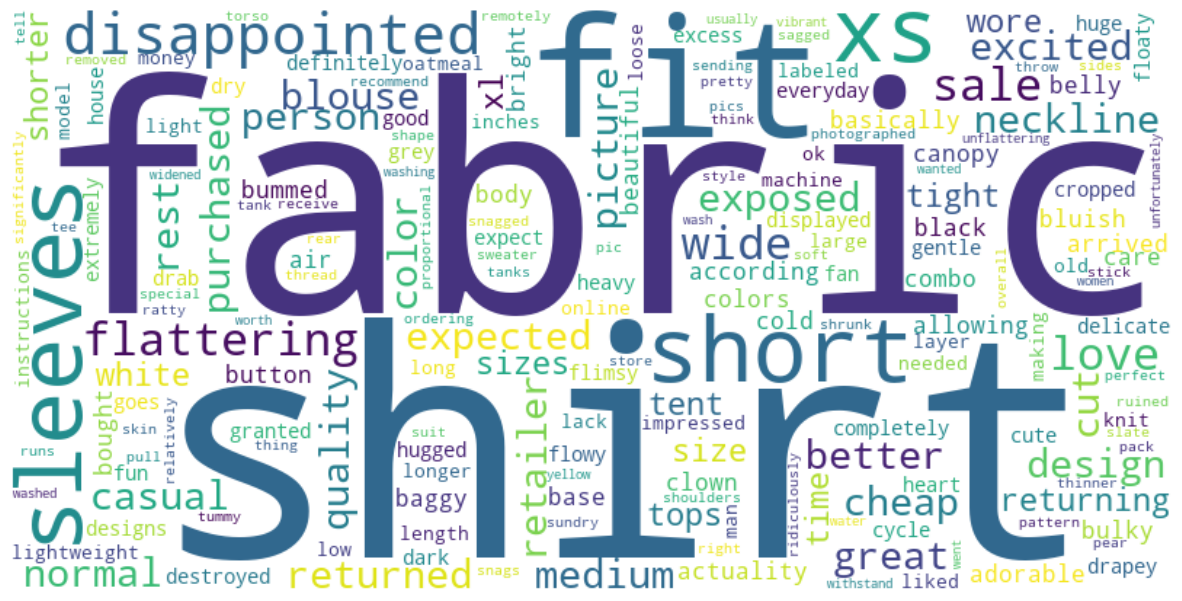

In [176]:
custom_stop_words = ['just', 'really', 'look','looked','wasn', 'received','trying','looking','started','isn','didn','felt', 'did','does', 'wear','know', 'couldn','tried', 'looks', 'way', 'ordered', 'dress', 'like', 'thought', 'doesn', 'don','ve','going','isnt', 'come','try', 'got' ] 

combined_stop_words = ENGLISH_STOP_WORDS.union(custom_stop_words) #Adding personalized words 

combined_stop_words_list = list(combined_stop_words) #Note to self: convert into a list for analysis

vectorizer = CountVectorizer(stop_words=combined_stop_words_list)

matrix = vectorizer.fit_transform(knits['review_text'])
frequent_words = vectorizer.get_feature_names_out()
word_counts = matrix.sum(axis=0)
word_freq = dict(zip(frequent_words, word_counts.tolist()[0]))
#sorted_word_freq = sorted(word_freq.items(), key=lambda item: item[1], reverse=True)[:20] # Top 20 words
#sorted_word_freq

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  #Note to self: off the axis
plt.show()

The words ‘fabric’, ‘shirt’ and ‘fit’ seem to be the most common this time. Let’s have a closer look at these reviews.

In [77]:
def contains_key_words(text):
    words = word_tokenize(text.lower())  #tokenization
    return 'fabric' in words or 'shirt' in words

filtered_df = lowest_avg_ratings[lowest_avg_ratings['review_text'].apply(contains_key_words)]
filtered_df = lowest_avg_ratings[(lowest_avg_ratings['class_name'] == 'Knits') & 
                             (lowest_avg_ratings['division_name'] == 'General')]

display(filtered_df[['rating', 'review_text', 'clothing_id']])

,rating,review_text,clothing_id
2167,1,"I was excited to receive this top. it looked great online, vibrant colors with the beautiful detail on the sleeves. when i tried it on, the fabric looked and felt cheap. it is not a flowy top. do not recommend it.",870
14516,1,I was really disappointed when i tried this top on. the design and cut of the neckline is very bulky and just off. the cut of the top overall was just off.,881
2660,1,"I purchased this top on sale and was really excited about the style. it fit great the first time i wore it. i washed it once, according to the care instructions. after washing it in cold water and allowing it to air dry, it was basically ruined. it shrunk up in length widened out about two inches. i'm pretty bummed about it because it was cute.",868
2666,1,I love sundry and their fun designs--i was disappointed because the fabric is very thin and the dark part of the heart is not black but bluish slate grey. it is just not what i expected from the picture. i bought the xs and it felt baggy on the body.,878
10267,1,I was very disappointed in the quality of this top. the first time i wore it it snagged right in the front. i had to pull the thread under so it wasn't exposed. i put it in the wash in the gentle cycle and it was destroyed with several more snags when i removed it from the machine. this top is extremely delicate and doesn't withstand normal everyday casual wear although it's s casual lightweight sweater. now it's just a wear around the house ratty throw around shirt.,879
4993,1,"I got this shirt in a medium, my normal retailer size and while the short fit, the front is cropped! i am a fan of the tops that are shorter in the front and longer in the back, however this was just too short in the front. my belly button was exposed, and that wasn't the look displayed on the model. unfortunately this top is going back to the store.",865
5569,1,This shirt would be perfect if i needed a canopy on my tent. this shirt runs ridiculously large. purchased a medium and it should be labeled an xl. no impressed with the pattern in person. looks cheap. will be returning.,880
5062,1,Even on sale sale...this tank is not worth the money. the design in the back is adorable & would expect it to be so much better quality but the fabric is flimsy(think old man white tanks that come in a pack) completely see through and lack of shape..i wanted to love this but definitely photographed significantly better than actuality!,871
1787,1,"Ordered a l and xl, the sleeves were so tight on both sizes but the rest of the shirt was wide and loose. the tight sleeves were not proportional with the rest of the shirt. both sizes had to be returned.",857
1319,1,It's short and wide. not a good combo for anyone who isn't stick thin.,860


A brief scan of the above reviews makes it clear that the quality of the fabric used to produce the knits seems to be the main problem for these clients

#### 7. Conclusion 

The dataset analyzed comprised customer reviews from  e-commerce clothing  shop. The reviews predominantly reflected a positive perception, with about 55% of the ratings being 5 stars. When categorizing the data by product classes, it became apparent that Dresses were the best-selling items, while Trends received the lowest number of reviews. An age-based analysis across different divisions revealed that the Intimates division attracted a slightly younger audience but had the least number of purchases. The General division had the highest number of reviews, followed by General Petite, with Intimates ranking third. In identifying products with the lowest average ratings, Blouses, Dresses, Knits, and Sweaters were noted as having the most.
For Sentiment Analysis, Textblob and VADER tools were applied to the dataset, with customized thresholds for this specific analysis. Key findings included VADER’s superior accuracy compared to Textblob. Both tools struggled to interpret texts associated with neutral ratings accurately, and also found it difficult to accurately classify the ratings of reviews with longer texts, perhaps due to unrelated terms and resulting confusion.
Unfortunately, of the two tools used in this study, neither were satisfactorily accurate to garner reliable business insights alone, both with correlation coefficients below 0.5. This is an important finding, because I would not suggest applying these tools in a business context with similar datasets. Perhaps they would work better with other datasets, though. Using only two Rule-Based sentiment Analysis tools, neither of which were particularly accurate, left me with limited scope for business insights from the tools themselves. If these were more accurate, I may be able to recommend the use of these tools in a similar business case when sentiment analysis is required to prescribe ratings to textual reviews.
From a business perspective, recommendations were formulated based on specific reviews that stood out during the analysis. These insights are instrumental in understanding customer preferences and areas needing improvement, however I’d liked to have applied further analysis in this section.
I’d like to take this project further, but for now, this is where I will leave it. I accept the limitations of this study and recognise many potential further applications of Sentiment Analysis for Business Insights. Here is a list of my ideas of next steps for this project, albeit non-exhaustive:
1. We could have performed a deeper analysis based on Age categories, finding out the preferences of each age category. This could have potentially fed into business insights, knowing which age groups prefer which product classes, for example contributing to future marketing efforts.
2. The 100 lowest ratings insights could have been developed further by applying a weighting to each Class based on the weighting of that Class in overall ratings. This could have provided a fairer assessment of which products are the most disliked. This also could have been compared with a weighting based on overall sales, for a better understanding of which products attract worse reviews.
3. Both tools used followed the Rule-Based Analysis approach. Another approach, such as a Data-Driven Analysis approach, could be more successful. For example, I would expect a machine-learning algorithm applied to a larger dataset, such as a Large Language Model, to be much more accurate than the Rule-Based tools used in this study. They should be better able to identify sentiment when presented with lengthier, even ironic, reviews, and also with shorter reviews as well.
4. If the data could be sourced, VADER’s remit seems like it could be applied to social media comments about the items bought from the store, as this would be more similar to its training dataset. It would be interesting to see how the accuracy ratio differs between ‘standard’-style reviews, as in this project, to snappier social-style reviews, such as replies, tags and mentions.
5. Again, if data could be sourced to enrich and profile the reviewer data, such as source of review, demographic indicators (location, marital status), economic indicators (overall income, disposable income, amount spent per year on clothes), and timeframes (when the product was bought), we could perform much more sectoral analysis and find out more exciting business insights.

In [79]:
import pandas as pd
# Assuming you have your DataFrame `df` already loaded
# Group by 'clothing_id' and aggregate the numerical fields with mean and non-numeric fields with first
mean_df = df_Vader.groupby('clothing_id').agg({
'age': 'mean',
'rating': 'mean',
'recommended_ind': 'mean',
'positive_feedback_count': 'mean',
'tb_pol': 'mean',
'tb_subj': 'mean',
'compound': 'mean',
'neg': 'mean',
'neu': 'mean',
'pos': 'mean',
'division_name': 'first', # Get the first occurrence
'department_name': 'first', # Get the first occurrence
 'class_name': 'first' # Get the first occurrence
}).reset_index()
# Calculate the weighted Vadar score as a mean of relevant fields
mean_df['weighted_vadar'] = (mean_df['compound'] + mean_df['neg'] + mean_df['neu'] + mean_df['pos']) / 4
# Display the resulting DataFrame
print(mean_df)

      clothing_id        age    rating  recommended_ind   
0               1  36.666667  4.000000         0.666667  \
1               2  28.000000  4.000000         1.000000   
2               3  36.000000  5.000000         1.000000   
3               4  28.000000  5.000000         1.000000   
4               5  39.000000  5.000000         1.000000   
...           ...        ...       ...              ...   
1167         1200  24.000000  3.000000         0.000000   
1168         1202  42.000000  4.333333         1.000000   
1169         1203  39.142857  4.428571         0.714286   
1170         1204  39.000000  4.500000         1.000000   
1171         1205  51.500000  5.000000         1.000000   

      positive_feedback_count    tb_pol   tb_subj  compound       neg   
0                    0.333333  0.358650  0.545636  0.701433  0.058667  \
1                    0.000000 -0.145525  0.645988  0.699600  0.064000   
2                    0.000000  0.222222  0.422222  0.840200  0.000000   

In [80]:
# Save the DataFrame to a CSV file
mean_df.to_csv('../data/final_vader.csv', index=False)